In [5]:
import os
import sys 
import numpy as np
import matplotlib.pyplot as plt
import sys 
import mdtraj
from nglview import show_ase, show_file, show_mdtraj
import torch

## Set up systems

In [45]:
from ase.lattice.cubic import FaceCenteredCubic
from ase import units

size = 4
L = 4.0
device = 3

from ase.lattice.cubic import FaceCenteredCubic
from ase import units

atoms = FaceCenteredCubic(directions=[[1, 0, 0], 
                                    [0, 1, 0], 
                                    [0, 0, 1]],
                          symbol='H',
                          size=(size, size, size),
                          latticeconstant=L,
                          pbc=True)

from torchmd.system import System
system = System(atoms, device=device)
system.set_temperature(298.0)

In [46]:
show_ase(system)

NGLWidget()

## Set up equations of motions

In [47]:

# parameter for SchNet 
params = {
    'n_atom_basis': 128,
    'n_filters': 128,
    'n_gaussians': 128,
    'n_convolutions': 4,
    'cutoff': 5.0,
    'trainable_gauss': False
}


# Define prior potential 
lj_params = {'epsilon': 0.05, 
             'sigma': 2.5, 
             'power': 12}

from torchmd.system import GNNPotentials,PairPotentials,System, Stack
from torchmd.potentials import ExcludedVolume
from nff.train import get_model


pair = PairPotentials(ExcludedVolume, lj_params,
                cell=torch.Tensor(system.get_cell_len()), 
                device=device,
                cutoff=8.0,
                ).to(device)

model = get_model(params)
GNN = GNNPotentials(model, system.get_batch(), system.get_cell_len(), cutoff=5.0, device=system.device)
model = Stack({'gnn': GNN, 'pair': pair})


from torchmd.md import NoseHooverChain 
diffeq =NoseHooverChain(model, 
            system,
            Q=50.0, 
            T=298.0 * units.kB,
            num_chains=5, 
            adjoint=True).to(device)

## Set up observation function

In [48]:
from torchmd.observable import rdf, vacf

# Set up observable 
obs = rdf(system, nbins=100, r_range=(0, 5) )
vacf_obs = vacf(system, t_range=10)

## Simulate

In [49]:
from torchmd.md import Simulations

# Set up simulations 
sim = Simulations(system, diffeq)

# Simulate 
v_t, q_t, pv_t = sim.simulate(steps=100, frequency=5, dt=0.25 *units.fs)

## compute observables

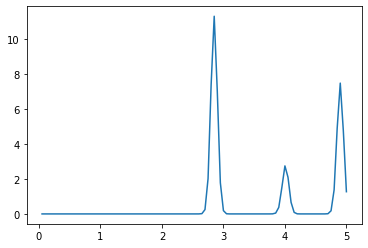

In [50]:
# compute observable 
_, bins, g = obs(q_t)
plt.plot(bins.detach().cpu().numpy()[1:],  g.detach().cpu().numpy() )